# Correlation Analysis


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import plotly.graph_objects as go




from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.HDF5_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_indicator_dict



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import natural_sensor_order, natural_structure_order, structure_2_sensor, error_indicators, bools_2_meta, rain_gauges

2024-11-19 11:09:26.959 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [55]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

In [56]:
sensor_metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
starttime = sensor_metadata['StartTime'].min()
endtime = sensor_metadata['EndTime'].max()

In [57]:
save_folder = FIGURES_DIR / 'analysis' / 'correlation'
os.makedirs(save_folder, exist_ok=True)

### Load clean data

In [58]:
clean, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean')

In [59]:
# restructure columns
clean = clean[rain_gauges + natural_sensor_order]

### Load rain events

In [60]:
# load the rain events
rain_events = pd.read_csv(REFERENCE_DIR / 'clf_rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])
print(rain_events.shape)
rain_events.head()

(2033, 4)


,start,end,duration,total_rain
0,2010-01-11 18:37:00,2010-01-12 03:12:00,530,123.296
1,2010-01-27 13:53:00,2010-01-27 16:17:00,159,36.689
2,2010-01-29 23:51:00,2010-01-30 02:21:00,165,43.327
3,2010-01-31 02:53:00,2010-01-31 03:48:00,70,23.345
4,2010-02-02 11:22:00,2010-02-02 15:20:00,253,69.968


### Filter data

- add hour buffer

In [61]:
# filter data to only include rain events
# - want 3 hours before and 3 hours after
timestamps = []
for _, row in rain_events.iterrows():
    timestamps.extend(pd.date_range(row['start'] - pd.Timedelta(hours=5), row['end'] + pd.Timedelta(hours=5), freq='1min'))

filtered_clean = clean.loc[timestamps].copy()

## Matrix correlation

In [62]:
corr = clean.corr()


# Create the mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to the correlation matrix
masked_corr = corr.mask(mask)


In [63]:

# Create the heatmap trace
heatmap = go.Heatmap(
    z=corr.values,
    x=corr.columns.tolist(),
    y=corr.index.tolist(),
    # color from blue to red
    colorscale='RdBu',
    #colorscale='RdYlGn', 
    # add text in each cell
    text=corr.values,
    texttemplate='%{text:.2f}',
    hovertemplate='Correlation: %{text:.2f}<extra></extra><br>%{y}<br>%{x}',
    showscale=True,
    reversescale=False,
    zmin=-1,
    zmax=1,
    xgap=1,
    ygap=1,
)


# Create the layout
layout = go.Layout(
    #title='Correlation Heatmap',
    xaxis=dict(tickangle=-45),  # Rotate x-axis labels
    yaxis=dict(autorange='reversed'), # Invert the y-axis
    height=900,
    width=1100,
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)
# Save the plot as png
fig.write_image(save_folder / 'correlation_matrix.png', scale=2)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
# Show the plot
fig.show()


- Some level sensors correlate completely, but they measure the same thing
    - i.e. one increases and the other increases proportionally
- Position is negative, because typically locked gate/low during heavy rain, e.g. especially its basin
- Rain gauges don't have so much correlation
    - maybe band would be interesting to investigate?

- does it make sense to model base don close/clustered sensor

In [64]:
corr = filtered_clean.corr()


# Create the mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Apply the mask to the correlation matrix
masked_corr = corr.mask(mask)


In [65]:

# Create the heatmap trace
heatmap = go.Heatmap(
    z=corr.values,
    x=corr.columns.tolist(),
    y=corr.index.tolist(),
    # color from blue to red
    colorscale='RdBu',
    #colorscale='RdYlGn', 
    # add text in each cell
    text=corr.values,
    texttemplate='%{text:.2f}',
    hovertemplate='Correlation: %{text:.2f}<extra></extra><br>%{y}<br>%{x}',
    showscale=True,
    reversescale=False,
    zmin=-1,
    zmax=1,
    xgap=1,
    ygap=1,
)


# Create the layout
layout = go.Layout(
    #title='Correlation Heatmap',
    xaxis=dict(tickangle=-45),  # Rotate x-axis labels
    yaxis=dict(autorange='reversed'), # Invert the y-axis
    height=900,
    width=1100,
)

# Create the figure
fig = go.Figure(data=[heatmap], layout=layout)
# Save the plot as png
fig.write_image(save_folder / 'correlation_matrix_filtered.png', scale=2)
# tight layout
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
# Show the plot
fig.show()


## Cross-Correlation

If a variable is constant, it flattens the line, since no variation is there to correlate with
- thus, we remove values, if the base variable continues to be zero beyond the lags we are checking

In [69]:
# Function to compute cross-correlation for lags and plot them
def plot_cross_correlation(df, base_variable, lag_range=20, width=900, height=450):
    """Plot cross-correlation of a base variable with all other variables in the dataframe."""
    variables = df.columns

    # Generate colors using Plotly's 'tab20' color palette
    colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},1)' for r, g, b in plt.get_cmap('tab20')(np.linspace(0, 1, len(variables)))[:, :3]]

    # Initialize an empty Plotly figure
    fig = go.Figure()

    mins = []
    maxs = []
    # Add small variable noise to separate the lines
    for i, variable in enumerate(variables):
        if variable != base_variable:
            cross_correlations = [df[base_variable].corr(df[variable].shift(lag)) for lag in range(-lag_range, lag_range+1)]
            # Add small noise to separate the lines
            cross_correlations += np.array(0.003 * i)
            fig.add_trace(go.Scatter(
                x=list(range(-lag_range, lag_range+1)),
                y=cross_correlations,
                mode='lines',
                name=f'{variable}',
                line=dict(color=colors[i], width=2),
                showlegend=True,
                opacity=1,
                text=[variable]*len(cross_correlations),
                texttemplate='%{text:.2f}',
                hovertemplate='%{text}<br>Lag: %{x}<br>Correlation: %{y:.2f}<extra></extra>'
            ))
            mins.append(min(cross_correlations))
            maxs.append(max(cross_correlations))

    # Update layout for titles, axes labels, and grid
    fig.update_layout(
        xaxis_title='Lags',
        yaxis_title='Correlation Coefficient',
        # make legend fill the entire plot area
        legend=dict(x=1.1, y=0.5),
        width=width, height=height,
        margin=dict(l=40, r=200, t=40, b=40),  # Adjust to accommodate legend
        plot_bgcolor='white'

    )

    # set x and y limits
    fig.update_xaxes(range=[-lag_range, lag_range])
    fig.update_yaxes(range=[min(mins)-0.05, max(maxs)+0.05])

    # Add grid lines
    fig.update_xaxes(showgrid=True, gridcolor='LightGray')
    fig.update_yaxes(showgrid=True, gridcolor='LightGray', range=[min(mins)-0.05, max(maxs)+0.05])
    # add a central line
    fig.update_xaxes(zeroline=True, zerolinecolor='Gray', zerolinewidth=1)
    # add a x=0 line
    fig.update_yaxes(zeroline=True, zerolinecolor='Gray', zerolinewidth=1)
    
    # tight layout
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
    return fig

In [70]:
fig = plot_cross_correlation(filtered_clean, '5425', lag_range=180, width=1100, height=450)
fig.write_image(save_folder / 'cross_correlation.png', scale=2)
fig.show()


Interpretation:

- Peak at Lag 3: This indicates that the second time series is significantly correlated with the first time series when shifted three time units (e.g., days, weeks, months) ahead.
    - pos: second leads the first
    - neg: first leads the second
- Negative Peak: A negative peak suggests an inverse relationship. When one series increases, the other decreases.


#### Max lags

In [89]:
# Add small variable noise to separate the lines
base_variable = '5425'
lag_range = 180
max_lag = {}
for i, variable in enumerate(natural_sensor_order): 
    if variable != base_variable or variable not in rain_gauges:
        cross_correlations = [filtered_clean[base_variable].corr(filtered_clean[variable].shift(lag)) for lag in range(-lag_range, lag_range+1)]
        lag = np.argmax(cross_correlations) - lag_range
        max_lag[variable] = lag

In [152]:
# add a empty lag
max_lag[' '] = np.nan

neg_list = [v for k, v in max_lag.items() if (v < 0)]# and v != -lag_range)]
pos_list = [v for k, v in max_lag.items() if (v > 0)]# and v != lag_range)]
max_lag['Average negative'] = np.mean(neg_list if neg_list else [0])
max_lag['Average positive'] = np.mean(pos_list if pos_list else [0])

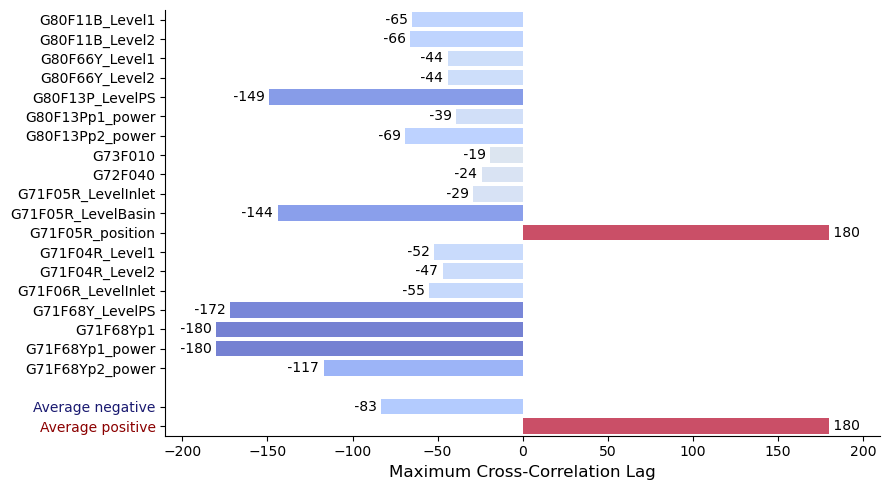

In [153]:

# Prepare the data
categories = list(max_lag.keys())
values = list(max_lag.values())

# Create the figure and axis
fig, ax = plt.subplots(figsize=(9, 5))


cmap = plt.cm.coolwarm
max_value = max(abs(value) for value in values)
norm = plt.Normalize(vmin=-max_value, vmax=max_value)


# Create the horizontal bar plot with color based on the normalized values
# bars = ax.barh(categories, values, color=cmap(norm(values)), alpha=0.7)
for i, (value, name) in enumerate(zip(values, categories)):
    color = cmap(norm(value))
    alpha = 0.7
    ax.barh(name, value, color=color, alpha=alpha)
    ha = 'right' if value < 0 else 'left'
    if not np.isnan(value):
        ax.text(value, i, f' {value:.0f} ', ha=ha, va='center', fontsize=10)
    else:
        # remove its tick
        ax.yaxis.get_major_ticks()[i].set_visible(False)
# Set labels and title
ax.set_xlabel('Maximum Cross-Correlation Lag', fontsize=12)
ax.set_xlim(-lag_range-30, lag_range+30)
ax.set_ylim(-0.5, len(categories)-0.5)
ax.invert_yaxis()

# remove spines
ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)

# Modify a specific y-axis tick (for example, change the color of the tick for 'Average')
for label in ax.get_yticklabels():
    text = label.get_text()
    if 'Average' in text:
        color = 'midnightblue' if 'negative' in text else 'darkred'  
        label.set_color(color)  # Change the tick label color to purple


# Layout adjustment
plt.tight_layout()
plt.savefig(save_folder / 'max_cross_correlation_lag.png', dpi=300)
plt.show()


- model window should be 1.5 hours?

In [ ]:
rain_gauges

['5425', '5427']

In [ ]:
base_variable = '5425'
plot_cross_correlation(raw, base_variable, lag_range=120)

- So 5425 precedes 5427 but the other varialbes do not precede 5427

#### Cross-Correlatio: Decending down-stream

In [ ]:
# for i, structure in enumerate(natural_structure_order):
#     print(structure)
#     columns = list(raw.columns)
#     structure_vars = [col for col in columns if structure in col]
#     structure_idxs = [columns.index(var) for var in structure_vars]
#     min_index = min(structure_idxs)
#     for i, structure_var in enumerate(structure_vars):
#         print(structure_var)
#         plot_cross_correlation(raw.iloc[:, min_index:], structure_var, lag_range=120, width=900, height=300)


- Nothing interesting

#### Cross-Correlation: circular relationships

In [ ]:
# circular_relationship = ['G80F11B', 'G80F66Y']
# cricular_relationship_vars = [col for col in columns if any([structure in col for structure in circular_relationship])]
# for base_variable in cricular_relationship_vars:
#     print(base_variable)
#     plot_cross_correlation(raw[cricular_relationship_vars], base_variable, lag_range=120)


- No interesting relation, just similar, and relation weakens for higher lags.
- All have a soft normal distribution shape

In [ ]:
circular_relationship = ['G71F06R', 'G71F68Y']
cricular_relationship_vars = [col for col in columns if any([structure in col for structure in circular_relationship])]
for base_variable in cricular_relationship_vars:
    print(base_variable)
    plot_cross_correlation(raw[cricular_relationship_vars], base_variable, lag_range=120)

G71F06R_LevelInlet


G71F68Y_LevelPS


G71F68Yp1


- Increased flow from pumping -> increased level, how come?

#### Cross-Correlation with storage pipe

In [ ]:
storage_pipe_relation = ['G71F04R', 'G71F05R', 'G71F06R', 'G71F68Y']
storage_pipe_relation_vars = [col for col in columns if any([structure in col for structure in storage_pipe_relation])]
storage_pipe_relation_vars += ['5425', '5427']
storage_pipe_vars = [col for col in columns if 'G71F68Y' in col]

for base_variable in storage_pipe_vars:
    print(base_variable)
    plot_cross_correlation(raw[storage_pipe_relation_vars], base_variable, lag_range=120)

G71F68Y_LevelPS


G71F68Yp1


- ?

### TODO:
- auto correlation as well?
